In [ ]:
import os
import glob
from PIL import Image

root_path = r"D:\LLM\heatmaps"
target_size = (224, 224)

image_files = glob.glob(os.path.join(root_path, "*.png"))
for img_path in image_files:
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
    img_resized.save(img_path.replace(".png", "_processed.png"))

In [13]:
!pip install open_clip_torch

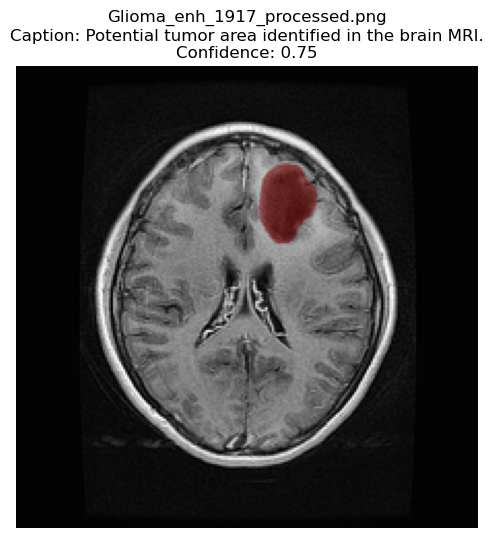

Glioma_enh_1917_processed.png:
Predicted Caption: Potential tumor area identified in the brain MRI.
Confidence: 0.75
--------------------------------------------------------------------------------


In [39]:
import os
import glob
from PIL import Image
import torch
import open_clip
import matplotlib.pyplot as plt
import random

model_name = "hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224"
model, preprocess = open_clip.create_model_from_pretrained(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

root_path = r"D:\LLM\heatmaps"
image_files = glob.glob(os.path.join(root_path, "*_processed.png"))

labels = [
    # tumor 
    "Glioma tumor identified in the brain MRI.",
    "Meningioma tumor detected in the brain MRI.",
    "Pituitary mass lesion observed in the pituitary gland region of the brain MRI.",
    "MRI suggests abnormal tumor growth in the brain.",
    "Focal lesion consistent with tumor presence in the brain MRI.",
    "Tumor region segmented in the brain MRI.",
    "Localized brain tumor visible in the MRI scan.",
    "Abnormal mass present in the brain MRI.",
    "Potential tumor area identified in the brain MRI.",
    "Abnormal tissue formation observed in the brain MRI.",
    "Aggressive tumor appearance noted on the MRI scan.",
    "Focal tumor-like lesion seen in the brain MRI.",
    "Lesion detected in the brain MRI consistent with focal pathology.",
    "Brain tumor region clearly segmented in the MRI.",
    "Abnormal mass visualized in the brain MRI.",
    "Tumor site identified in contrast-enhanced brain MRI.",
    "Localized tumor detected with strong signal intensity in the brain MRI.",

    # no tumor
    "Normal brain MRI with no abnormal findings.",
    "Healthy brain MRI with no evidence of tumor.",
    "Brain MRI shows normal anatomy without abnormalities.",
    "No signs of tumor observed in the brain MRI.",
    "Clear brain MRI without any abnormal growth.",
    "Brain MRI appears unremarkable and within normal limits.",
    "Normal findings on brain MRI.",
    "No pathological features identified in the brain MRI."
    
    
]



text_inputs = tokenizer(labels).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# num_images_to_show = 50
#num_images=random.sample(image_files,10)
'''
for img_path in image_files[:num_images_to_show]:
    image = Image.open(img_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarities = (image_features @ text_features.T).squeeze(0)
        top_idx = similarities.argmax().item()
        caption = labels[top_idx]

        raw_conf = similarities[top_idx].item()
        confidence = (raw_conf + 1) / 2
========================================================
for img_path in num_images:
    image = Image.open(img_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarities = (image_features @ text_features.T).squeeze(0)
        top_idx = similarities.argmax().item()
        caption = labels[top_idx]

        raw_conf = similarities[top_idx].item()
        confidence = (raw_conf + 1) / 2
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f"{os.path.basename(img_path)}\nCaption: {caption}\nConfidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()

    print(f"{os.path.basename(img_path)}:")
    print(f"Predicted Caption: {caption}")
    print(f"Confidence: {confidence:.2f}")
    print("-" * 80)
'''
img_path = random.choice(image_files)
image = Image.open(img_path).convert("RGB")
image_tensor = preprocess(image).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_tensor)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    similarities = (image_features @ text_features.T).squeeze(0)
    top_idx = similarities.argmax().item()
    caption = labels[top_idx]
    raw_conf = similarities[top_idx].item()
    confidence = (raw_conf + 1) / 2

# Display image and result
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"{os.path.basename(img_path)}\nCaption: {caption}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()

# Print caption
print(f"{os.path.basename(img_path)}:")
print(f"Predicted Caption: {caption}")
print(f"Confidence: {confidence:.2f}")
print("-" * 80)


In [41]:
import openai

client = openai.OpenAI(
    api_key="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",
    base_url="https://openrouter.ai/api/v1"
)

def generate_medical_report(caption):
    prompt = (
    "You are an experienced radiologist. Based on the following high-level observation, "
    "generate a concise, professional, and medically accurate radiology report. "
    "Do not mention image format, colors, overlays, or patient information like name or age.\n\n"
    f"Observation: {caption}\n\n"
    "Radiology Report:"
)


    response = client.chat.completions.create(
        model="mistralai/mistral-7b-instruct",
        messages=[
            {"role": "user", "content": prompt}
        ],
        max_tokens=300,
        temperature=0.4,
    )

    return response.choices[0].message.content

report = generate_medical_report(caption)
print(report)

 "Imaging findings suggest the possible presence of a mass lesion within the brain. Further evaluation with contrast-enhanced sequences and correlation with clinical history is recommended for characterization and potential guidance for biopsy or follow-up."


In [51]:
from openai import OpenAI

large_model_client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key="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",  # For large model
)

free_model_client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key="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",  # For fallback
)

def generate_medical_report(caption: str) -> str:
    prompt = (
    "You are an experienced radiologist. Based on the following high-level observation, "
    "generate a concise, professional, and medically accurate radiology report. "
    "Do not mention image format, colors, overlays, or patient information like name or age.\n\n"
    f"Observation: {caption}\n\n"
    "Radiology Report:"
)

    try:
        response = large_model_client.chat.completions.create(
            model="mistralai/mistral-7b-instruct",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=300,
            temperature=0.4,
        )
        return "[mistral-7b-instruct]\n" + response.choices[0].message.content.strip()

    except Exception as e:
        print("Large model failed, falling back to free model:", e)

        response = free_model_client.chat.completions.create(
            model="mistralai/devstral-small:free",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=200,
            temperature=0.3,
        )
        return "[devstral-small:free]\n" + response.choices[0].message.content.strip()


report = generate_medical_report(caption)
print("Generated Report:\n", report)


Generated Report:
 [mistral-7b-instruct]
Imaging findings reveal a well-circumscribed, non-enhancing lesion within the sella turcica, suggestive of a pituitary mass. The lesion exhibits focal signal abnormality on all sequences, raising suspicion for a pituitary adenoma. Further characterization and differentiation from other pituitary tumors may require additional imaging or laboratory studies. Recommendation for endocrinology consultation and further workup is advised.
